Imports

In [305]:
%matplotlib inline
# Basic
from collections import OrderedDict
from datetime import timedelta
# Numbers
import pandas as pd
import numpy as np
# Graphic
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
# Models
import pmdarima as pm
from arch.univariate import ZeroMean, GARCH, Normal # 3 components of GARCH model

Some useful funcs

In [306]:
# Summarizes object characteristics
def check_types_df(df):
    print(
        "Shape: ", df.shape, "\n"
        "Attributes: ", df.attrs, "\n"
        )
    print(df.info())
def do_call(which, args=None, kwargs = None):
    if args is None and kwargs is not None:
        return which(**kwargs)
    elif args is not None and kwargs is None:
        return which(*args)
    else:
        return which(*args, **kwargs)

Data retrival

In [307]:
# LOAD NAMES
dmkt = "C:/Users/Keegan/OneDrive/1 Studies/2021 - 2022/5003W/3 - Dissertation/5-Data/cleaned/univariate/market_indices/market_names.csv"
mkt_names = pd.read_csv(dmkt).values.tolist()
mkt_names = [item for sublist in mkt_names for item in sublist]

# LOAD DATA
dd = "C:/Users/Keegan/OneDrive/1 Studies/2021 - 2022/5003W/3 - Dissertation/5-Data/cleaned/univariate/market_indices/"
dirs = []
data = OrderedDict()
for i in range(len(mkt_names)):
    # concat strings to get directories
    nm = mkt_names[i]
    directory = dd+nm+".csv"
    # store
    dirs.append(directory)
    data[nm] = pd.read_csv(directory)
    del directory, nm

Constant specifications

In [308]:
# SCALING FACTOR
SCALE = 100

# Date parameters
E1 = pd.to_datetime("2020-01-13")
E2 = pd.to_datetime("2020-01-24")
E3 = pd.to_datetime("2020-02-24")
E4 = pd.to_datetime("2020-03-09")

CUT1 = pd.to_datetime("2019-04-29")
CUT2 = pd.to_datetime("2020-06-01")

# Plot parameters
SCATTER = 25
ALPHA = 0.8
LINEWIDTH = 1.5

Notebook Settings

In [309]:
# Returns
var_mode = 'log_prices' # alternative = 'log_returns'

# Plotting settings
plt.style.use('seaborn')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

plt.rc('font', **font)
plt.rc('xtick', labelsize=12)  
plt.rc('ytick', labelsize=12)

date_form  = DateFormatter('%Y-%m-%d')

In [438]:
# Toggle Settings
store_stats_results = True
show_plots = True
save_figs = False

Data Wrangling

In [337]:
# select data
MKT = "SPX.Index"
dataset = data[MKT].copy(deep=True)
# format dates
dataset['date'] = pd.to_datetime(dataset['date'].values)
# change colname for ease of use
dataset = dataset.rename(columns={'date':'date', MKT:'val'})
# keep prices for ML
prices = dataset.copy(deep=True)

if var_mode == 'log_returns':
    # extract price level, calc log_returns, store as dataset
    log_returns = np.log(dataset.val.shift(-1) / dataset.val)
    log_returns = log_returns[~np.isnan(log_returns)]

    dataset.val = log_returns
    del log_returns

elif var_mode == 'log_prices':
    # extract price level, calc log_prices, store as dataset
    log_prices = np.log(np.copy(dataset.val.values))
    log_prices = log_prices[~np.isnan(log_prices)]

    dataset.val = log_prices
    del log_prices
else:
    Exception("Variable calculation not specified. Please specify var_mode with one of the following: ['log_returns', 'log_prices']")

# set data splitting parameters
date1 = E1
date2 = CUT2+timedelta(days=365)

# split dataset
Y = dataset.val
X = pd.concat([pd.to_datetime(dataset.date), pd.Series(range(len(Y)))], axis=1).rename({'date':'date',0:'index'},axis=1)
# X_in = X.index[X.date < date1]
# X_out = X.index[X.date >= date1]
train = dataset[(dataset["date"] < date1)] # & (dataset['date'] > pd.to_datetime("2016-01-01")) 
test = dataset[(dataset["date"] >= date1)]
# Inspect
print(
    'TABULAR DATA:', '\n',
    'train.shape: ', train.shape, '\n',
    'test.shape: ', test.shape
    )

# retain date seqs
dtrain, dtest = pd.to_datetime(train.date), pd.to_datetime(test.date)
# format structures (and dtypes) for arima
Y, train, test = Y.values, train.val.values, test.val.values
# Inspect and compare
print(
    'DATA VECTORS:', '\n',
    'train.shape: ', train.shape, '\n',
    'test.shape: ', test.shape
    )

TABULAR DATA: 
 train.shape:  (3026, 2) 
 test.shape:  (532, 2)
DATA VECTORS: 
 train.shape:  (3026,) 
 test.shape:  (532,)


Directories

In [311]:
d_model_results = 'C:/Users/Keegan/OneDrive/1 Studies/2021 - 2022/5003W/3 - Dissertation/5-Data/results/fanomal/stats_models/'
d_arima = d_model_results+'arima_results/'+MKT+'/'
d_arima_plots = d_arima+'plots/'
d_garch = d_model_results+'garch_results/'+MKT+'/'
d_garch_plots = d_garch+'plots/'

# Ensure appropriate nested directory exits
from pathlib import Path
Path(d_arima).mkdir(parents=True, exist_ok=True)
Path(d_arima_plots).mkdir(parents=True, exist_ok=True)
Path(d_garch).mkdir(parents=True, exist_ok=True)
Path(d_garch_plots).mkdir(parents=True, exist_ok=True)

ARIMA

In [312]:
ORDER = (1,1,1)
# construct arima model of order ORDER, keeping data out of sample
arima = pm.ARIMA(order=ORDER, out_of_sample_size=int(test.shape[0]))
fit = arima.fit(Y)
# predict in sample
pred_in = fit.predict_in_sample(start=1, end=Y.shape[0], dynamic=False, return_conf_int=True)
# extract upper & lower confidence intervals of predictions
lw = pd.DataFrame({'date':dataset.date.values, 'lower':[pred_in[1][i][0] for i in range(pred_in[1].shape[0])]}).set_index('date')
up = pd.DataFrame({'date':dataset.date.values, 'upper':[pred_in[1][i][1] for i in range(pred_in[1].shape[0])]}).set_index('date')

In [313]:
# # Plots Autocorrelation. Keeping in case I want to make some adjustments
# from statsmodels.graphics.tsaplots import acf, plot_acf
# diff = np.diff(Y,n=1)
# acorr = acf(diff,nlags=50)
# plot_acf(diff, lags=50, auto_ylims=True)
# plt.show()
# # Plots ARIMA(1,1,1) residuals' distribution
# resid = (Y - pred_in[0])
# sns.distplot([fit.resid()[1:-1],resid[1:-1]])

In [314]:
# Build pd.DataFrames to make plotting easier
predicted = pd.DataFrame({
    'date':dataset.date.values,
    # 'actual':Y,
    'predicted':pred_in[0],
    'lower':[pred_in[1][i][0] for i in range(pred_in[1].shape[0])],
    'upper':[pred_in[1][i][1] for i in range(pred_in[1].shape[0])]
    }).set_index('date')
train_test = {
    'train':pd.DataFrame({'date':dtrain,'train':train}).set_index('date'),
    'test':pd.DataFrame({'date':dtest,'test':test}).set_index('date')
}
actual = dataset.set_index('date')

ARIMA plots

In [315]:
MIN_VAL = 1 + 2980
MAX_VAL = MIN_VAL + test.shape[0] - 450
if show_plots:
    # Plot actual test vs. forecasts:
    fig, ax = plt.subplots()
    ax.scatter(
        dataset.date.values[MIN_VAL:MAX_VAL],
        dataset.val.values[MIN_VAL:MAX_VAL],
        marker = '.',
        s = SCATTER,
        alpha = 1,
        color = 'black',
        label = "SP500"
        )
    ax.plot(
        predicted.iloc[MIN_VAL:MAX_VAL],
        alpha = ALPHA,
        linewidth = LINEWIDTH,
        label = predicted.columns
        )

    ax.set_facecolor('whitesmoke')
    ax.fmt_xdata = date_form
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    fig.legend(loc=8, ncol=2, prop={'size':15})
    # fig.autofmt_xdate()
    fig.set_size_inches(18.5, 10.5)
    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
    plt.figure(num=1, figsize=(8,6))
    plt.title('ARIMA(1,1,1) fitted: '+str(MKT), fontsize=20)

    plt.show()
else:
    print("Not showing plot.")

if show_plots & save_figs:
    fig.savefig((d_arima_plots+MKT+'_ARIMA'+str(ORDER)+'_full-fit_CLOSE_UP.png'), dpi=400, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

Not showing plot.
Not storing plot.


In [316]:
MIN_VAL = 1 + 3000
MAX_VAL = Y.shape[0] - 350
if show_plots:
    fig, ax = plt.subplots()
    ax.scatter(
        dataset.date.values[MIN_VAL:MAX_VAL],
        dataset.val.values[MIN_VAL:MAX_VAL],
        marker = '.',
        s = SCATTER,
        alpha = 1,
        color = 'black',
        label = "SP500"
        )
    ax.plot(
        predicted.iloc[MIN_VAL:MAX_VAL],
        alpha = ALPHA,
        linewidth = LINEWIDTH,
        label = predicted.columns
        )

    ax.set_facecolor('whitesmoke')
    ax.xaxis.set_major_formatter(date_form)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    fig.legend(loc=8, ncol=2, prop={'size':15})
    # fig.autofmt_xdate()
    fig.set_size_inches(18.5, 10.5)
    plt.figure(num=1, figsize=(8,6))
    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
    plt.title('ARIMA(1,1,1) in-sample-predictions: '+str(MKT), fontsize=20)
    plt.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_arima_plots+'_ARIMA(1,1,1)_IN_SAMPLE_PRED_(close_up).png', dpi=400, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')
# 

Not showing plot.
Not storing plot.


In [317]:
MIN_VAL = 1 + 2980
MAX_VAL = Y.shape[0] - 350
if show_plots:
    # Plot actual test vs. forecasts:
    fig, ax = plt.subplots()
    ax.scatter(
        dataset.date.values[MIN_VAL:MAX_VAL],
        dataset.val.values[MIN_VAL:MAX_VAL],
        marker = '.',
        s = SCATTER,
        alpha = 1,
        color = 'black',
        label = "SP500"
        )
    ax.plot(
        predicted.iloc[dtrain.shape[0]:MAX_VAL],
        alpha = ALPHA,
        linewidth = LINEWIDTH,
        label = predicted.columns
        )
    ax.plot(
        predicted.iloc[MIN_VAL:dtrain.shape[0]],
        alpha = ALPHA,
        linewidth = LINEWIDTH,
        label = predicted.columns
        )

    ax.set_facecolor('whitesmoke')
    ax.xaxis.set_major_formatter(date_form)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    fig.legend(loc=8, ncol=2, prop={'size':15})
    fig.autofmt_xdate()
    fig.set_size_inches(18.5, 10.5)
    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
    plt.figure(num=1, figsize=(8,6))
    plt.title('ARIMA(1,1,1) fitted: '+str(MKT), fontsize=20)
    plt.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_arima_plots+'_ARIMA(1,1,1)_full-fit_(close_up).png', dpi=400, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

Not showing plot.
Not storing plot.


GARCH Modelling

In [319]:
H = 10

arima_resids = pd.DataFrame(
    {'date':dataset.date.values[1:], 'arima_resids':fit.resid()[1:]*SCALE},
    copy=True).set_index('date')
# In-sample Model
arch_s = ZeroMean(arima_resids)
arch_s.volatility = GARCH(p=ORDER[0],o=1,q=ORDER[2])
arch_s.distribution = Normal(seed=1)
arch_s_fit = arch_s.fit(last_obs = E1)
# Out-sample Analytic Forecasts
f = arch_s_fit.forecast(horizon = H, start=E1)
# Conditional Volatilities
fvol = f.variance['h.01'].pow(0.5)          # 1-period forward forecast conditional volatility
svol = arch_s_fit.conditional_volatility    # sample estimated conditional volatility

# Full Sample Model
garch = ZeroMean(arima_resids)
garch.volatility = GARCH(p=ORDER[0],o=1,q=ORDER[2])
garch.distribution = Normal(seed=1)
garch_fit = arch_s.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1677582420.6263652
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4184.16828721853
Iteration:      3,   Func. Count:     20,   Neg. LLF: 5432.669091828316
Iteration:      4,   Func. Count:     27,   Neg. LLF: 3965.701360839627
Iteration:      5,   Func. Count:     33,   Neg. LLF: 3950.996159779608
Iteration:      6,   Func. Count:     38,   Neg. LLF: 3950.3340404611245
Iteration:      7,   Func. Count:     44,   Neg. LLF: 3949.3412312681403
Iteration:      8,   Func. Count:     50,   Neg. LLF: 3949.1240695788138
Iteration:      9,   Func. Count:     55,   Neg. LLF: 3949.1163030498046
Iteration:     10,   Func. Count:     60,   Neg. LLF: 3949.116293559593
Iteration:     11,   Func. Count:     64,   Neg. LLF: 3949.116293559961
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3949.116293559593
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations

c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


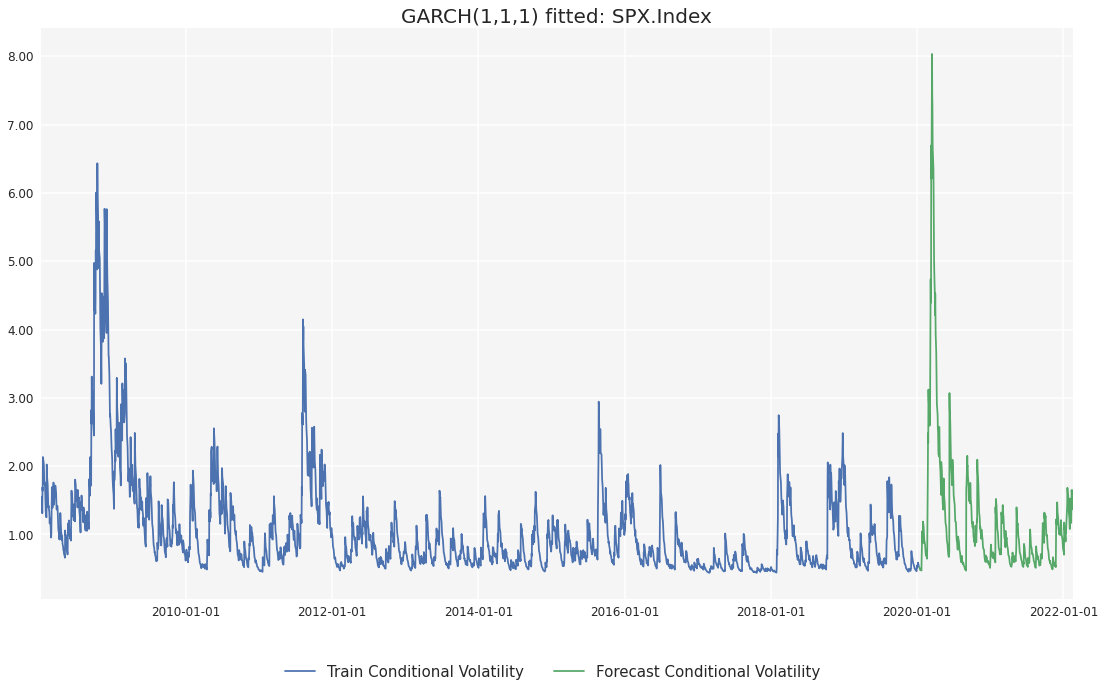

Not storing plot.


In [439]:
if show_plots:
    # Plot conditional volatilities
    fig, ax = plt.subplots()
    # ax.plot(garch_fit.conditional_volatility, color='black', label='Full-fit Conditional Volatility')
    ax.plot(svol, label='Train Conditional Volatility')
    ax.plot(fvol, label='Forecast Conditional Volatility')

    ax.set_facecolor('whitesmoke')
    ax.margins(x=0)
    ax.xaxis.set_major_formatter(date_form)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    fig.legend(loc=8, ncol=2, prop={'size':15})
    # fig.autofmt_xdate()
    fig.set_size_inches(18.5, 10.5)
    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
    plt.figure(num=1, figsize=(8,6))
    plt.title('GARCH(1,1,1) fitted: '+str(MKT), fontsize=20)
    plt.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_garch_plots+'GRJ-GARCH(1,1,1)_in-sample_vs_out-sample.png', dpi=400, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

In [321]:
quiet = svol[svol.index>'2012-01-01']
gfc = svol[svol.index<'2012-01-01']
covid = fvol

In [322]:
if show_plots:
    sns.distplot(arima_resids, color='orange')
    sns.distplot(arch_s_fit.resid)
    plt.title('Scaled Model Residuals')
    plt.legend(labels=['ARIMA residuals','GJR-GARCH residuals'])
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_model_results+'ARIMA(1,1,1)_vs_GRJ-GARCH(1,1,1)_residual distributions.png', dpi=400, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

Not showing plot.
Not storing plot.


Wrangling and storing of results

In [323]:
######################
# RECORD GARCH RESULTS
# Residuals
if store_stats_results == True:
    garch_fit.resid.to_csv(d_garch+MKT+'_GARCH'+str(ORDER)+'_residuals'+'.csv') 
else:
    print('Not storing'+' GJR-GARCH'+str(ORDER)+' residuals.')

# Extract and store garch model results
# Model characteristics
df_temp = pd.DataFrame(garch_fit.summary().tables[0])
# slice pieces out
tmp1 = df_temp.iloc[0:5,0:2]
tmp2 = df_temp.iloc[0:5,2:4]
tmp3 = df_temp.iloc[6:8,0:2]
tmp4 = df_temp.iloc[5:8,2:4]
# fix colnames
tmp1.columns = ['Item','Value']
tmp2.columns = ['Item','Value']
tmp3.columns = ['Item','Value']
tmp4.columns = ['Item','Value']
# merge and store
if store_stats_results == True:
    pd.concat([tmp1,tmp2,tmp3,tmp4]).set_index('Item').to_csv(d_garch+MKT+' GJR-GARCH'+str(ORDER)+'_characteristics'+'.csv')
    # cleanup
    del df_temp, tmp1, tmp2, tmp3, tmp4
else:
    print('Not storing'+' GJR-GARCH'+str(ORDER)+' characteristics.')
    # cleanup
    del df_temp, tmp1, tmp2, tmp3, tmp4

# Model parameters
df_temp = pd.DataFrame(garch_fit.summary().tables[1])
# restructure & store
df_temp.columns = df_temp.iloc[0]
tmp_cols = ['name']
[tmp_cols.append(str(n)) for n in list(df_temp.columns)[1:]]
df_temp.columns = tmp_cols
if store_stats_results == True:
    df_temp.drop(0).set_index('name').to_csv(d_garch+MKT+'_GJR-GARCH'+str(ORDER)+'_model_params'+'.csv')
    # cleanup
    del df_temp, tmp_cols
else:
    print('Not storing'+' GJR-GARCH'+str(ORDER)+' model params.')
    # cleanup
    del df_temp, tmp_cols

######################
# RECORD ARIMA RESULTS
# Residuals
if store_stats_results == True:
    arima_resids.to_csv(d_arima+MKT+'_ARIMA'+str(ORDER)+'_residuals'+'.csv')
else:
    print('Not storing'+' ARIMA'+str(ORDER)+' residuals.')

# Extract and store garch model results
# Model characteristics
df_temp = pd.DataFrame(fit.summary().tables[0])
nobs = int(str(df_temp.iloc[5,1]).replace(" ",""))
# slice unruly pieces out
tmp1 = df_temp[[0,1]]
tmp2 = df_temp[[2,3]].drop([5,6],axis=0).rename({2:0,3:1},axis=1)
# wrangle
df_temp = pd.concat([tmp1,tmp2])
df_temp.index = range(len(df_temp))
df_temp = df_temp.drop(5, axis=0)
df_temp.index = range(len(df_temp))
df_temp.iloc[4,1]=tuple([0, nobs])
df_temp.iloc[0:1,1:2] = MKT
df_temp = df_temp.rename({0:'Item',1:'Value'}, axis=1).set_index('Item')
if store_stats_results == True:
    df_temp.to_csv(d_arima+MKT+'_ARIMA'+str(ORDER)+'_characteristics'+'.csv')
    # cleanup
    del df_temp, tmp1, tmp2
else:
    print('Not storing'+' ARIMA'+str(ORDER)+' characteristics.')
    # cleanup
    del df_temp, tmp1, tmp2

# ARIMA Model coefs & sigs
df_temp = pd.DataFrame(fit.summary().tables[1])
# restructure & store
df_temp.columns = df_temp.iloc[0]
tmp_cols = ['name']
[tmp_cols.append(str(n)) for n in list(df_temp.columns)[1:]]
df_temp.columns = tmp_cols
if store_stats_results == True:
    df_temp.drop(0).set_index('name').to_csv(d_arima+MKT+'_ARIMA'+str(ORDER)+'_model_params'+'.csv')
    # cleanup
    del df_temp, tmp_cols
else:
    print('Not storing'+' ARIMA'+str(ORDER)+' model params.')
    # cleanup
    del df_temp, tmp_cols

# ARIMA statistics
df_temp = pd.DataFrame(fit.summary().tables[2])
tmp1 = df_temp[[0,1]]
tmp2 = df_temp[[2,3]].rename({2:0,3:1},axis=1)
if store_stats_results == True:
    pd.concat([tmp1,tmp2]).rename({0:'Statistic',1:'Value'}, axis=1).set_index('Statistic').to_csv(d_arima+MKT+'_ARIMA'+str(ORDER)+'_statistics'+'.csv')
    # cleanup
    del df_temp, tmp1, tmp2
else:
    print('Not storing'+' ARIMA'+str(ORDER)+' statistics.')
    # cleanup
    del df_temp, tmp1, tmp2

In [464]:
garch_resids = garch_fit.std_resid #garch_fit.resid

normal_returns = prices.set_index('date').pct_change()*SCALE
normal_returns = normal_returns.dropna()
squared_returns = normal_returns**2
squared_returns = squared_returns.rename({'date':'date','val':'squared_returns'}, axis=1)
# log_returns = pd.DataFrame({'date':prices.date, 'log_returns':prices.val.divide(prices.val.shift(1)).subtract(1)}).set_index('date').dropna()
volatility = pd.DataFrame({'date':svol.index,'volatility':pd.concat([svol.dropna(),fvol.dropna()])}).set_index('date')
arimaXgarch = arima_resids.arima_resids*garch_resids
arimaXgarch.columns = 'arimaXgarch'

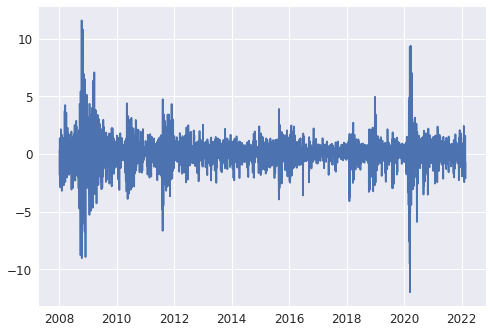

In [415]:
plt.plot(normal_returns)

c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

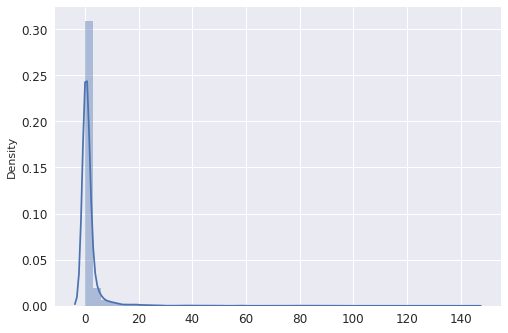

In [421]:
sns.distplot(normal_returns**2/SCALE*SCALE)
# sns.distplot(normal_returns)

In [466]:
features = pd.concat([
    normal_returns,
    squared_returns,
    arima_resids.copy(deep=True),
    garch_resids,
    volatility,
    arimaXgarch],axis=1).rename(
        {'val':'normal_returns',
        'squared_returns':'squared_returns',
        'arima_resids':'arima_resids',
        # 'resid':'garch_resids',
        'std_resid':'garch_resids',
        'volatility':'volatility',
        0:'arimaXgarch'
        }, axis=1)
features.tail()

,normal_returns,squared_returns,arima_resids,garch_resids,volatility,arimaXgarch
date,,,,,,
2022-02-14,-0.384055,0.147498,-0.707974,-0.425611,1.575086,0.301322
2022-02-15,1.576674,2.485902,1.455613,0.926612,1.468099,1.348789
2022-02-16,0.088122,0.007766,0.269127,0.182324,1.369616,0.049068
2022-02-17,-2.117314,4.483017,-2.150167,-1.577460,1.646483,3.391802
2022-02-18,-0.716624,0.513550,-1.057221,-0.644283,1.616362,0.681150


In [432]:
all(garch_fit.resid.values == arima_resids.arima_resids.values)

True

In [458]:
garch_fit.std_resid

date
2008-01-07    0.198584
2008-01-08   -1.364619
2008-01-09    0.686663
2008-01-10    0.648877
2008-01-11   -0.958618
                ...   
2022-02-14   -0.425611
2022-02-15    0.926612
2022-02-16    0.182324
2022-02-17   -1.577460
2022-02-18   -0.644283
Name: std_resid, Length: 3557, dtype: float64

In [295]:
pd.qcut(arima_resids.arima_resids, q=10, retbins=True)[1]

array([-11.63368102,  -1.26909185,  -0.6237493 ,  -0.30439171,
        -0.09886608,   0.06205513,   0.22361386,   0.44158138,
         0.71227478,   1.18857612,  10.68201493])